In [1]:
import cv2
import os
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import json
import math
import face_alignment

In [2]:
import xml.etree.ElementTree as ET
import numpy as np
import json
from matplotlib import pyplot as plt
from utils.landmark_util import extract_landmarks_media_pipe
from scipy import signal
from scipy.stats import multivariate_normal
from scipy.spatial import distance

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [8]:
# extract_landmarks_media_pipe("rolling_in_the_deep_1.mp4",
#                                  "F:/MASC/Motion_paint/example_videos", save_annotated_video=True)
# extract_landmarks_media_pipe("EvanHead.MOV",
#                                  "F:\\MASC\\Jali_sing\\validation\\faceware session 2022 Apr 24st\\", save_annotated_video=True)


extract_landmarks_media_pipe("IMG_1929.MOV",
                                 "/Users/evansamaa/Downloads/", save_annotated_video=True)


MoviePy - Writing audio in /Users/evansamaa/Downloads/IMG_1929/audio.mp3


MoviePy - Done.


100%|██████████| 642/642.0 [00:26<00:00, 24.57it/s]


'/Users/evansamaa/Downloads/IMG_1929/2D_mediapipe_landmark.npy'

# Input block

In [3]:
lmPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/rolling_in_the_deep_1/raw_mediapipe_landmark.npy"
videoPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/rolling_in_the_deep_1.mp4"

# lmPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/Child_in_time_2/raw_mediapipe_landmark.npy"
# lmPath = "E:/Facial Feature Motion Clip/rollingInTheDeep/raw_mediapipe_landmark.npy"
# lmPath = "/Volumes/KINGSTON/csc2521/raw_mediapipe_landmark.npy"
# outputPath = "/Volumes/EVAN_DISK/emp/child_in_time_motion.json"
outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
t_segment = [0, 169]
t_ref = 0
# info of target animation
start = 0
fps = 30
min_cutoff = 0.0001
beta = 1.5

In [4]:
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)

staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(lmPath)


### Rotation algorithm from http://web.stanford.edu/class/cs273/refs/umeyama.pdf

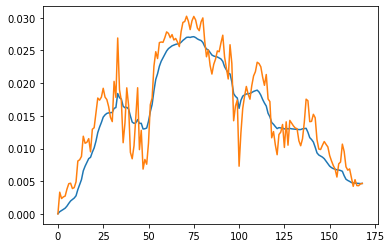

In [5]:
def compute_rotation(X, Y):
    # the algorithm uses X and Y notation, where the input dimension should be (M x N)
    # where M is the number of dimension and N is the number of points. the output is
    # R, c, t, where they satisfies min_{R, c, t} ||(c*R*X+t) - Y||^2
    mu_x = X.mean(axis=1)
    mu_y = Y.mean(axis=1)
    rho2_x = X.var(axis=1).sum()
    rho2_y = Y.var(axis=1).sum()
    cov_xy = 1.0 / X.shape[1] * (Y-np.expand_dims(mu_y, axis=1))@(X-np.expand_dims(mu_x, axis=1)).T
    # SVD on the covariance matrix
    U, D, V_T = np.linalg.svd(cov_xy)
    D = np.diag(D)
    # prepare sign flipping matrix S, which need to be altered at some point
    S = np.identity(3)
    # update matrix S based on the rank of cov_xy
    if np.linalg.matrix_rank(cov_xy) >= X.shape[0]-1:
        if (np.linalg.det(cov_xy) < 0):
            S[-1,-1] = -1 
    else:
        det_U = np.linalg.det(U)
        det_V = np.linalg.det(V_T)
        if (det_U * det_V < 0):
            S[-1,-1] = -1  
    # compute rotation and scale and translation
    R = U@S@V_T
    c = (1.0 / rho2_x) * np.trace(D @ S)
    t = mu_y - c * R @ mu_x
    # X_prime = c * R @ frame_i.T + np.expand_dims(t, 1)
    # X_prime = rotated_frame_i.T
    return R, c, np.expand_dims(t, 1)
def rotateToNeutral(neutralPose, data, staticIndices, returnRotation=False):
    # neturalPose should be a numpy array of shape (N, M)
    # data should be a numpy array of shape (T, N, M)
    # staticIndices should be a list of integers 
    outData = np.zeros(data.shape)
    R_out = []
    for i in range(0, data.shape[0]):
        frame_t = data[i,staticIndices]
        R, c, t = compute_rotation(frame_t.T, neutralPose[staticIndices].T)
        if returnRotation:
            R_out.append(R)
#         print(t)
        outData[i] = (c * R @ data[i].T + t).T
    if returnRotation:
        return outData, R_out
    else:
        return outData
def smoothing_factor(t_e, cutoff):
    r = 2 * math.pi * cutoff * t_e
    return r / (r + 1)
def exponential_smoothing(a, x, x_prev):
    return a * x + (1 - a) * x_prev
class OneEuroFilter:
    def __init__(self, t0, x0, dx0=0.0, min_cutoff=1.0, beta=0.0,
                 d_cutoff=1.0):
        """Initialize the one euro filter."""
        # The parameters.
        self.min_cutoff = float(min_cutoff)
        self.beta = float(beta)
        self.d_cutoff = float(d_cutoff)
        # Previous values.
        self.x_prev = float(x0)
        self.dx_prev = float(dx0)
        self.t_prev = float(t0)

    def __call__(self, t, x):
        """Compute the filtered signal."""
        t_e = t - self.t_prev
        # The filtered derivative of the signal.
        a_d = smoothing_factor(t_e, self.d_cutoff)
        dx = (x - self.x_prev) / t_e
        dx_hat = exponential_smoothing(a_d, dx, self.dx_prev)

        # The filtered signal.
        cutoff = self.min_cutoff + self.beta * abs(dx_hat)
        a = smoothing_factor(t_e, cutoff)
        x_hat = exponential_smoothing(a, x, self.x_prev)

        # Memorize the previous values.
        self.x_prev = x_hat
        self.dx_prev = dx_hat
        self.t_prev = t
        return x_hat
def runEuro(t, data):
    out = np.zeros(data.shape)
    out[0] = data[0]
    one_euro_filter = OneEuroFilter(t[0], data[0],min_cutoff=min_cutoff,beta=beta)
    for i in range(1, len(t)):
        out[i] = one_euro_filter(t[i], data[i])
    return out
def constrainedOneEuroFilter(data, dataRange, keyFrames):
    # data should be a numpy array of shape (n, )
    # dataRange should be a list of two element, a starting frame and an ending frame [start, end)
    # keyFrames should be a list of keyframes that the model needs is constraint to
    
    # construct partitions of the signal
    dataPartitions = []
    start = 0
    end = dataRange[1] - dataRange[0]
    for i in range(0, len(keyFrames)):
        kf = keyFrames[i] - start # conform it to indexing of array
        if i == 0:
            if (kf>=1):
                dataPartitions.append(data[0:kf])
        else:
            prev_kf = keyFrames[i-1] - start
            dataPartitions.append(data[prev_kf:kf])
    dataPartitions.append(data[keyFrames[-1] - start:])
    out_dataPartition = []
    # using 1 euro filter to perform changes
    for i in range(0, len(dataPartitions)):
        if i < len(dataPartitions)-1:
            forward = dataPartitions[i]
            backward = np.flip(dataPartitions[i])
            
            t = np.arange(0, forward.shape[0])
            alpha = np.arange(forward.shape[0], 0, -1)/forward.shape[0]
#             plt.plot(backward)
            forward = runEuro(t, forward) * alpha
            backward = np.flip(runEuro(t, backward) * alpha)
        
            out_dataPartition.append(forward + backward)
        else:
            forward = dataPartitions[i]
            t = np.arange(0, forward.shape[0])
            out_dataPartition.append(runEuro(t, forward))
    return np.concatenate(out_dataPartition)
def outputToFile(path, arr, fps, start):
    # the input should be in the form of a 2D array with shape [n, ]
    arr_length = arr.shape[0]
    dt = 1.0 / fps
    t_arr = np.arange(0, arr_length) * dt + start
    t_arr = t_arr.tolist()
    arr = arr / arr.max()
    v_arr = arr.tolist()
    
    output = {"t": t_arr, "v": v_arr}
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(output, f)
    return
def getSheerMat(dimensions=3):
    out = []
    if dimensions == 3:
        sheer_x_y = np.eye(3)
        sheer_x_y[1,0] = 1
        sheer_x_z = np.eye(3)
        sheer_x_z[2,0] = 1
        
        sheer_y_x = np.eye(3)
        sheer_y_x[0,1] = 1
        sheer_y_z = np.eye(3)
        sheer_y_z[2,1] = 1
        
        sheer_z_x = np.eye(3)
        sheer_z_x[0,2] = 1
        sheer_z_y = np.eye(3)
        sheer_z_y[1,2] = 1
        
        stretch_x = np.eye(3)
        stretch_x[0, 0] = 2
        
        stretch_y = np.eye(3)
        stretch_y[1, 1] = 2
        
        stretch_z = np.eye(3)
        stretch_z[2, 2] = 2
        
        
        out = [sheer_x_y, sheer_x_z, sheer_y_x, sheer_y_z, sheer_z_x, sheer_z_y, stretch_x, stretch_y, stretch_z]
    return out
        

def shearBasis(landmarks, anchor, transformations):
    # this function expect pointCloud to be in the shape of [3, n]
    # anchor should be the shape [3, 1]
    # return a set of differential blendshapes that represents the pointCloud, centered
    # around the anchor, sheared in all 6 directions.
    # returns a list of arrays, with shape of [3, n], these are differential blendshapes
    
    out = []
    centered_landmarks = landmarks - anchor
    for trans in transformations:
        out.append((trans @ centered_landmarks + anchor - landmarks))
    return out, landmarks
def inverseIK(blendshapes, baseshape, target, indices):
    # baseshape and target should both in shape of [3, n]
    # blendshape is a list of arrays with shape [3, n]
    
    diff = (target[:, indices] - baseshape[:, indices]).reshape([target.shape[0]*len(indices), 1])
    B = []
    for i in range(0, len(blendshapes)):
        mat = blendshapes[i][:, indices].reshape([target.shape[0]*len(indices), ])
        B.append(np.expand_dims(mat, axis=0))
    B = np.concatenate(B, axis=0)
    w = np.linalg.inv(B@B.T)@B@diff
    return w
t = 70
def shearNormalization(data, neutral_frame, shear_landmarkSet, rotation=True, rotation_landmarkset=None):
    data_0 = neutral_frame
    out_data = []
    basis_transformation = getSheerMat()
    for t in range(0, len(data)):
        data_1 = data[t]
        shearCenter = [4]
        if rotation:
            R, c, t = compute_rotation(data_1[rotation_landmarkset].T, data_0[rotation_landmarkset].T)
            norm_data_1 = (c*R @ data_1.T+t).T
        else:
            norm_data_1 = data_1
        # do the shear transformtions
        basis, neutral = shearBasis(norm_data_1.T, norm_data_1[shearCenter].T, basis_transformation)
        # basis and neutralis that of the entire mesh
        w = inverseIK(basis, neutral, data_0.T, shear_landmarkSet)
        sheared_data_1 = neutral
        for i in range(0, len(basis)):
            sheared_data_1 = sheared_data_1 + w[i] * basis[i]
        sheared_data_1 = sheared_data_1.T
        out_data.append(np.expand_dims(sheared_data_1, axis=0))
    out_data = np.concatenate(out_data, axis=0)
    return out_data
def iterativeNormalization(data, neutral_frame, rotation_landmarkset, sheer_landmarkset):
    out_data = shearNormalization(data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset)
    out_data = shearNormalization(out_data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset)
    out_data = shearNormalization(out_data, neutral_frame, sheer_landmarkset, rotation=True, rotation_landmarkset=rotation_landmarkset)
    return out_data
def display_landmark(landmark_arr, fps):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    x_max = landmark_arr[:, :, 0].max()
    y_max = landmark_arr[:, :, 1].max()
    x_min = landmark_arr[:, :, 0].min()
    y_min = landmark_arr[:, :, 1].min()
    y_range = np.abs(y_max-y_min)
    x_range = np.abs(x_max-x_min)
    
    
    def update(i):
        label = 'timestep {0}'.format(i)
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        landmark_arr_i = landmark_arr[i]
        print(i)
        fig.clf()
        ax = plt.scatter(landmark_arr_i[:, 0], -landmark_arr_i[:, 1])
        ax = plt.scatter([x_min-x_range/10, x_max+x_range/10], [-y_min+y_range/10, -y_max-y_range/10])
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, landmark_arr.shape[0]), interval=fps)
    f = r"animation.avi" 
    writervideo = animation.FFMpegWriter(fps=25)
    anim.save(f, writer=writervideo)
min_cutoff = 0.0001
beta = 5
t_ref = 0
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[t_ref]
dataSegment = rotateToNeutral(ref_frame, dataSegment, staticLandmarkIndices)
leftBrowIndices = maping["brow"]["leftUpper"]+list(reversed(maping["brow"]["leftLower"]))+maping["brow"]["rightUpper"]+maping["brow"]["rightLower"]
leftBrowDeviation = np.sqrt(np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2).mean(1))
out = constrainedOneEuroFilter(leftBrowDeviation, t_segment, [t_ref, -1])
plt.plot(out)
plt.plot(leftBrowDeviation)
# outputToFile(outputPath, out, fps, start)

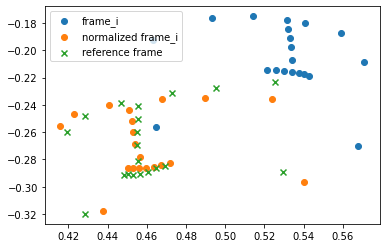

In [10]:
i=35
staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices)
plt.scatter(data[i, staticLandmarkIndices, 0], -data[i, staticLandmarkIndices,1], label="frame_i")
plt.scatter(normlalized_data[i, staticLandmarkIndices, 0], -normlalized_data[i, staticLandmarkIndices,1], label="normalized frame_i")
plt.scatter(data[0, staticLandmarkIndices, 0], -data[0, staticLandmarkIndices,1], marker="x", label="reference frame")
plt.legend()


# 1.2 quantitatively testing the normalization (the more points that are used the more likely there won't be as much warping)

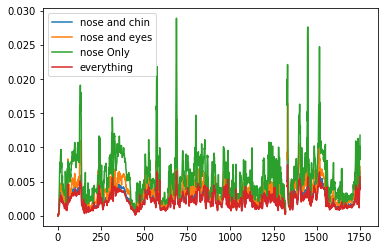

In [15]:
staticLandmarkIndices1 = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
staticLandmarkIndices2 = maping["eye"]["static"]+maping["nose"]["dorsum"]+maping["nose"]["tipLower"]
staticLandmarkIndices3 = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]
staticLandmarkIndicesAll = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["eye"]["static"]+maping["additional_anchors"]
# fitting using the nose and chind data
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices1)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="nose and chin")
# fitting using the nose and eye data
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices2)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="nose and eyes")
# fitting using nose only
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndices3)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="nose Only")
# fitting using nose, eye, chin data
normlalized_data = rotateToNeutral(data[0], data, staticLandmarkIndicesAll)
fitting_error = normlalized_data[:, staticLandmarkIndicesAll] - data[0, staticLandmarkIndicesAll]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="everything")
plt.legend()

This just shows that the more landmarks the better.

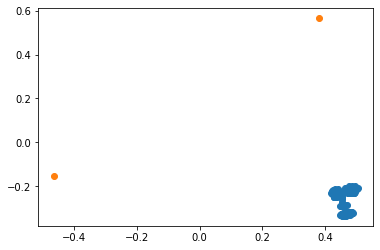

In [184]:
normlalized_data = rotateToNeutral(ref_frame, data, staticLandmarkIndices) 
normlalized_data = np.where(np.isnan(normlalized_data), normlalized_data[0, 0, 0], normlalized_data)
x_max = normlalized_data[:, :, 0].max()
y_max = (-normlalized_data[:, :, 1]).max()
x_min = normlalized_data[:, :, 0].min()
y_min = (-normlalized_data[:, :, 1]).min()

plt.scatter(normlalized_data[0, keypointIndicies, 0], -normlalized_data[0, keypointIndicies, 1])
plt.scatter([x_min, y_min], [x_max, y_max])

In [15]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
def display_landmark(landmark_arr, fps):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    x_max = landmark_arr[:, :, 0].max()
    y_max = landmark_arr[:, :, 1].max()
    x_min = landmark_arr[:, :, 0].min()
    y_min = landmark_arr[:, :, 1].min()
    y_range = np.abs(y_max-y_min)
    x_range = np.abs(x_max-x_min)
    
    
    def update(i):
        label = 'timestep {0}'.format(i)
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        landmark_arr_i = landmark_arr[i]
        print(i)
        fig.clf()
        ax = plt.scatter(landmark_arr_i[:, 0], -landmark_arr_i[:, 1])
        ax = plt.scatter([x_min-x_range/10, x_max+x_range/10], [-y_min+y_range/10, -y_max-y_range/10])
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, landmark_arr.shape[0]), interval=fps)
    f = r"animation.avi" 
    writervideo = animation.FFMpegWriter(fps=25)
    anim.save(f, writer=writervideo)

normlalized_data = rotateToNeutral(ref_frame, data, staticLandmarkIndices)    
# display_landmark(normlalized_data[0:10, keypointIndicies], 30)

# 2. Testing methods to compute contour changes 

### 2.1a General contour information, translation, whole video

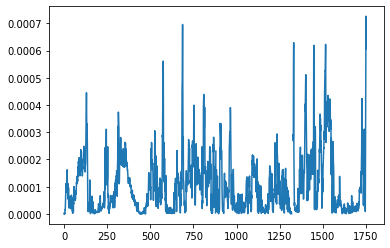

In [18]:
leftBrowIndices = maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]
nose_indices = maping["nose"]["dorsum"]+maping["nose"]["tip"]
leftBrowData = normlalized_data[:,leftBrowIndices]-normlalized_data[0:1,leftBrowIndices]

# leftBrowPositionData = leftBrowData.min(axis=1)
# plt.plot(leftBrowPositionData[:,1], label="min")
# leftBrowPositionData = leftBrowData.max(axis=1)
# plt.plot(leftBrowPositionData[:,1], label="max")
leftBrowPositionData = np.square(leftBrowData-leftBrowData[0:1]).mean(axis=1)
plt.plot(leftBrowPositionData[:,1], label="mean")

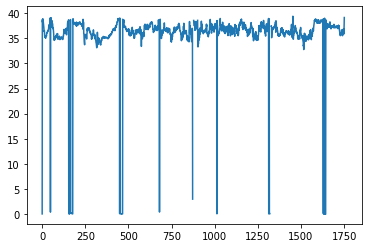

In [19]:
leftBrowIndices_loop = maping["brow"]["leftUpper"]+list(reversed(maping["brow"]["leftLower"]))
leftBrowData = normlalized_data[:,leftBrowIndices_loop]
refFrame = leftBrowData[0]
f_0 = turning_feature_vector(refFrame[:, 0:2])
dist = np.zeros((normlalized_data.shape[0], ))
for i in range(0, normlalized_data.shape[0]):
    dist[i] = np.square(f_0-turning_feature_vector(leftBrowData[i, :, 0:2])).sum()
plt.plot(dist)

### 2.1b General contour information, translation, segment of interest

In [36]:
t_segment = [0, 168]
t_ref = 159
staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
leftBrowIndices = maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]
nose_indices = maping["nose"]["dorsum"]+maping["nose"]["tip"]

In [33]:
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[t_ref]
dataSegment = rotateToNeutral(dataSegment[0], dataSegment, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
smoothed_signal = signal.savgol_filter(leftBrowDistanceFromNeutral, min(5, np.floor(leftBrowDistanceFromNeutral.shape[0]/2)*2-1), 1)
plt.plot(leftBrowDistanceFromNeutral[:], label="raw")
plt.plot(smoothed_signal, label="savgol")
t = np.arange(0, dataSegment.shape[0])
x_hat = np.zeros_like(leftBrowDistanceFromNeutral)
x_hat[0] = leftBrowDistanceFromNeutral[0]
one_euro_filter = OneEuroFilter(t[0], leftBrowDistanceFromNeutral[0],min_cutoff=min_cutoff,beta=beta)
for i in range(1, len(t)):
    x_hat[i] = one_euro_filter(t[i], leftBrowDistanceFromNeutral[i])
plt.plot(x_hat, label="1euro")
# x_hat = constrainedOneEuroFilter(leftBrowDistanceFromNeutral, t_segment, [t_ref])
# plt.plot(x_hat, label="2euro")
plt.legend()


ValueError: operands could not be broadcast together with shapes (96,20,3) (0,20,3) 

# 2.2 General contour information, shape contour, segment of interest

In [10]:
def relative_feature_vector(input_contour):
    input_contour_tiled = np.tile(input_contour, [1, input_contour.shape[0]])
    input_contour_T_tiled = np.tile(input_contour.reshape(input_contour.shape[0]*input_contour.shape[1],1).T, [input_contour.shape[0], 1])
    relative_dif = input_contour_tiled - input_contour_T_tiled
    relative_dif = relative_dif.reshape((input_contour.shape[0]*input_contour.shape[0],3))
    relative_dif = np.linalg.norm(relative_dif, axis=1)
    return relative_dif
def contour_t_comparison(input_contour_set, reference_frame):
    f0 = relative_feature_vector(reference_frame)
    out = np.zeros((input_contour_set.shape[0], ))
    for i in range(0, input_contour_set.shape[0]):
        fi = relative_feature_vector(input_contour_set[i])
        np.square(f0-fi).sum()
        out[i] = np.square(f0-fi).sum()
    return out
def outputToFile(path, arr, fps, start, angle=False):
    # the input should be in the form of a 2D array with shape [n, ]
    arr_length = arr.shape[0]
    dt = 1.0 / fps
    t_arr = np.arange(0, arr_length) * dt + start
    t_arr = t_arr.tolist()
    if not angle:
        arr = arr / arr.max()
    v_arr = arr.tolist()
    
    output = {"t": t_arr, "v": v_arr}
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(output, f)
    return
# outputToFile(outputPath, x_hat, fps, start)




# 2.3 General contour information, turning angle distance, segment of interest

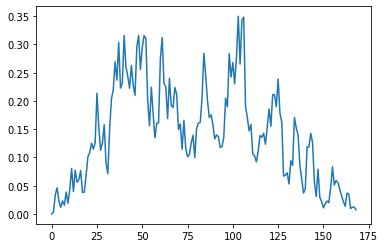

In [10]:
def turning_feature_vector(input_contour):
    # input contour should be shaped (n, 2), with m being the number of 2D dimensions X and Y
    v1 = np.zeros((input_contour.shape[0]+1, input_contour.shape[1]))
    v1[1:] = input_contour
    v1[0] = input_contour[-1]
    v2 = np.zeros((input_contour.shape[0]+1, input_contour.shape[1]))
    v2[0:-1] = input_contour
    v = v2-v1
    theta = np.arctan2(v[:, 0], v[:, 1])[0:-1]
#     print(theta)
    return theta
leftBrowIndices_loop = maping["brow"]["leftUpper"]+list(reversed(maping["brow"]["leftLower"]))
leftBrowData = dataSegment[:,leftBrowIndices_loop]
refFrame = leftBrowData[0]
f_0 = turning_feature_vector(refFrame[:, 0:2])
dist = np.zeros((dataSegment.shape[0], ))
for i in range(0, dataSegment.shape[0]):
    dist[i] = np.square(f_0-turning_feature_vector(leftBrowData[i, :, 0:2])).sum()
plt.plot(dist)

# 3. Use shear to correct landmarks

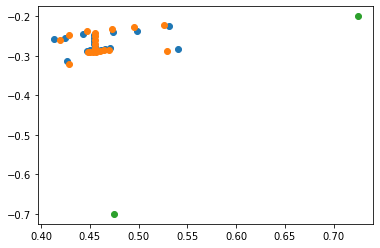

In [31]:
i = 90
iterativenormData = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices)
shearedData = shearNormalization(data, data[0], staticLandmarkIndices, rotation_landmarkset=staticLandmarkIndices)
sheared_data_1  = shearedData[i]
# plt.scatter(sheared_data_1[staticLandmarkIndices, 0], -sheared_data_1[staticLandmarkIndices, 1])
plt.scatter(iterativenormData[i][staticLandmarkIndices, 0], -iterativenormData[i][staticLandmarkIndices, 1])
plt.scatter(data[0][staticLandmarkIndices, 0], -data[0][staticLandmarkIndices, 1])
plt.scatter([0.475, 0.725], [-0.7, -0.2])
plt.show()

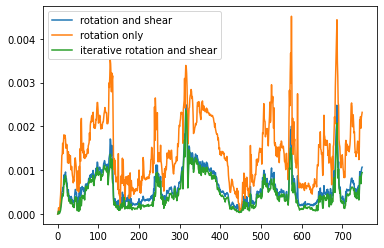

In [23]:
staticLandmarkIndices_alt = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+[127, 356, 132, 361]

# iterative_normalized_data_alt = iterativeNormalization(data, data[0], staticLandmarkIndices_alt, staticLandmarkIndices_alt)

iterative_normalized_data = iterativeNormalization(data[0:750], data[0], staticLandmarkIndices, staticLandmarkIndices)
shear_rotated_data = shearNormalization(data[0:750], data[0], staticLandmarkIndices, rotation=True, rotation_landmarkset=staticLandmarkIndices)
rotated_data = rotateToNeutral(data[0], data[0:750], staticLandmarkIndices)
fitting_error = shear_rotated_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="rotation and shear")
fitting_error = rotated_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="rotation only")
fitting_error = iterative_normalized_data[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
plt.plot(fitting_error, label="iterative rotation and shear")
# fitting_error = iterative_normalized_data_alt[:, staticLandmarkIndices] - data[0, staticLandmarkIndices]
# fitting_error = np.square(fitting_error).sum(axis=2).sum(axis=1)
# plt.plot(fitting_error, label="iterative rotation and shear alt")
plt.legend()

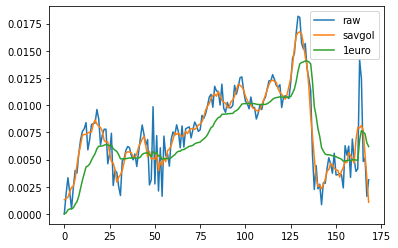

In [24]:



dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[0]
dataSegment = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices)
# leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices,1:2]-dataSegment[t_ref:t_ref+1,leftBrowIndices,1:2])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
smoothed_signal = signal.savgol_filter(leftBrowDistanceFromNeutral, min(5, np.floor(leftBrowDistanceFromNeutral.shape[0]/2)*2-1), 1)
plt.plot(leftBrowDistanceFromNeutral[:], label="raw")
plt.plot(smoothed_signal, label="savgol")
t = np.arange(0, dataSegment.shape[0])
x_hat = np.zeros_like(leftBrowDistanceFromNeutral)
x_hat[0] = leftBrowDistanceFromNeutral[0]
one_euro_filter = OneEuroFilter(t[0], leftBrowDistanceFromNeutral[0],min_cutoff=min_cutoff,beta=beta)
for i in range(1, len(t)):
    x_hat[i] = one_euro_filter(t[i], leftBrowDistanceFromNeutral[i])
plt.plot(x_hat, label="1euro")
plt.legend()
outputToFile(outputPath, x_hat, fps, 0)


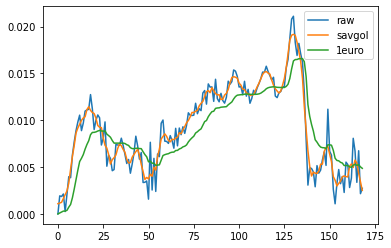

In [25]:
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[0]
dataSegment = rotateToNeutral(dataSegment[0], dataSegment, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices,1:2]-dataSegment[t_ref:t_ref+1,leftBrowIndices,1:2])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
smoothed_signal = signal.savgol_filter(leftBrowDistanceFromNeutral, min(5, np.floor(leftBrowDistanceFromNeutral.shape[0]/2)*2-1), 1)
plt.plot(leftBrowDistanceFromNeutral[:], label="raw")
plt.plot(smoothed_signal, label="savgol")
t = np.arange(0, dataSegment.shape[0])
x_hat = np.zeros_like(leftBrowDistanceFromNeutral)
x_hat[0] = leftBrowDistanceFromNeutral[0]
one_euro_filter = OneEuroFilter(t[0], leftBrowDistanceFromNeutral[0],min_cutoff=min_cutoff,beta=beta)
for i in range(1, len(t)):
    x_hat[i] = one_euro_filter(t[i], leftBrowDistanceFromNeutral[i])
plt.plot(x_hat, label="1euro")
# x_hat = constrainedOneEuroFilter(leftBrowDistanceFromNeutral, t_segment, [t_ref])
# plt.plot(x_hat, label="2euro")
plt.legend()


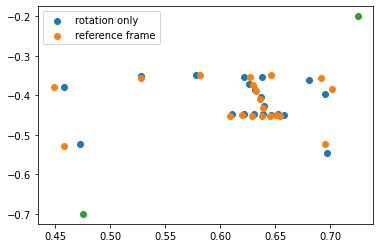

In [41]:
i = 20
iterativenormData = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices)
shearedData = shearNormalization(data, data[0], staticLandmarkIndices, rotation_landmarkset=staticLandmarkIndices)
rotated_data = rotateToNeutral(data[0], data, staticLandmarkIndices)
sheared_data_1  = shearedData[i]
# plt.scatter(sheared_data_1[staticLandmarkIndices, 0], -sheared_data_1[staticLandmarkIndices, 1])
# plt.scatter(iterativenormData[i][staticLandmarkIndices, 0], -iterativenormData[i][staticLandmarkIndices, 1], label="rotation and shear")
plt.scatter(rotated_data[i][staticLandmarkIndices, 0], -rotated_data[i][staticLandmarkIndices, 1], label="rotation only")
plt.scatter(data[0][staticLandmarkIndices, 0], -data[0][staticLandmarkIndices, 1], label="reference frame")
plt.scatter([0.475, 0.725], [-0.7, -0.2])
plt.legend()

# 3.1 comparison

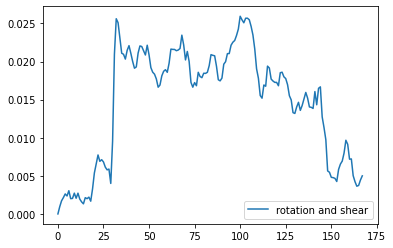

In [63]:
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[159]

dataSegment = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices,1:2]-dataSegment[t_ref:t_ref+1,leftBrowIndices,1:2])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
plt.plot(leftBrowDistanceFromNeutral[:], label="rotation and shear")

# dataSegment = iterativeNormalization(dataSegment, ref_frame, staticLandmarkIndices, staticLandmarkIndices)
# leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2)
# leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
# plt.plot(leftBrowDistanceFromNeutral[:], label="absolute positional difference")
plt.legend()


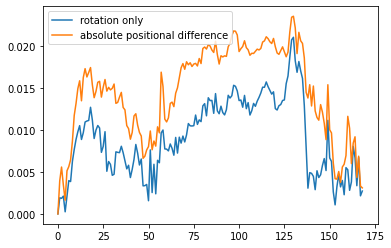

In [27]:
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[0]

dataSegment = rotateToNeutral(dataSegment[0], dataSegment, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices,1:2]-dataSegment[t_ref:t_ref+1,leftBrowIndices,1:2])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
plt.plot(leftBrowDistanceFromNeutral[:], label="rotation only")

dataSegment = rotateToNeutral(dataSegment[0], dataSegment, staticLandmarkIndices)
leftBrowDistanceFromNeutral = np.square(dataSegment[:,leftBrowIndices]-dataSegment[t_ref:t_ref+1,leftBrowIndices])[:,:,0:2].sum(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
plt.plot(leftBrowDistanceFromNeutral[:], label="absolute positional difference")
plt.legend()


# 4. C HMM implementation

(169, 1, 1)


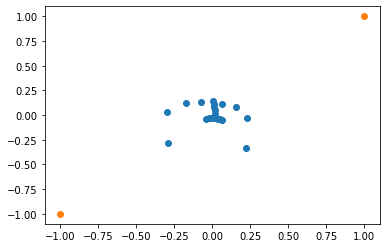

In [8]:
dataSegment = data[t_segment[0]:t_segment[1]]
Y = dataSegment[:,staticLandmarkIndices,:]
Y = Y - Y.mean(axis=1, keepdims=True)
Y = Y.reshape((Y.shape[0], len(staticLandmarkIndices) * 3, 1))
print(np.sqrt(np.square(Y).sum(axis=1, keepdims=True)).shape)
Y = Y / np.sqrt(np.square(Y).sum(axis=1, keepdims=True))

S = Y @ Y.transpose((0, 2, 1))
S = S.sum(axis=0)
eigen_values, eigen_vectors = np.linalg.eig(S)
miu = eigen_vectors[:, 0].T
miu = miu.reshape((len(staticLandmarkIndices), 3))
# plt.scatter(data[0][staticLandmarkIndices, 0], -data[0][staticLandmarkIndices, 1])
plt.scatter(miu[:, 0], -miu[:, 1])
plt.scatter([-1, 1], [-1, 1])

### NSSA Training - eye brows

In [99]:
leftBrowIndices = maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]


# noisy signal Y 
Y = data[t_segment[0]:t_segment[1]]
# center Y around mean
Y = Y - Y.mean(axis=1, keepdims=True)
# compute shape Z
Z = iterativeNormalization(Y, Y[59], staticLandmarkIndices, staticLandmarkIndices)
Z = Z[:, leftBrowIndices, 0:2] # dimensional reduction to keep only key points, and 2 Dimensions
# reshape Z
T, N, k = Z.shape
# centering matrix C:
C = np.eye(N*k) - (np.ones((N*k, 1)) @ np.ones((1, N*k)))/N/k
Z_flat = Z.reshape(T, N*k, 1)
Z_flat = np.expand_dims(C, axis=0) @ Z_flat
Z_flat = Z_flat / np.linalg.norm(Z_flat, axis=1, keepdims=True)
V_flat = np.zeros(Z_flat.shape) # tangent space coordinate
c_flat = np.zeros(Z_flat.shape) # 

# compute vt
for i in range(1, T):
    V_flat[i] = (np.eye(N*k) - Z_flat[i-1] @ Z_flat[i-1].T) @ Z_flat[i]
    # obtain the basis matrix
    T_z_im1 = (np.eye(N*k) - Z_flat[i-1] @ Z_flat[i-1].T) @ C
    U, _, _ = np.linalg.svd(T_z_im1)
    c_flat[i] = U.T @ Z_flat[i]

In [100]:
# compute learned AutoRegression matrix parameters
V_flat_outer = V_flat  @ V_flat.transpose((0, 2, 1))
cov_v = (V_flat_outer[1:].sum(axis=0))/(T-1)
R_v =  (V_flat[2:] @ V_flat[1:-1].transpose((0, 2, 1))).sum(axis=0)/(T-2)
A = R_v @ np.linalg.inv(cov_v)
temp = V_flat[2:] - np.expand_dims(A, 0) @ V_flat[1:-1]
cov_n = (temp @ temp.transpose((0, 2, 1))).sum(axis=0)/(T-2)

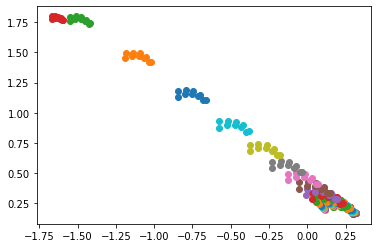

In [151]:
v_t = V_flat[1]
z_t = Z_flat[1]
N_sample = 1
for i in range(0, 100):
    noise = np.random.multivariate_normal(np.zeros(Z_flat[0, :, 0].shape), cov_n, N_sample)
    noise = np.expand_dims(noise, axis=2)
    v_t = A @ v_t
    z_t = np.sqrt(1 - v_t[k].T @ v_t[k]) * z_t + v_t[k]
    z_t_plot = z_t.reshape(Z[0].shape)
    plt.scatter(z_t_plot[:, 0], -z_t_plot[:, 1])

In [147]:
print(np.linalg.det(np.linalg.matrix_power(A, 96)))

0.06722645446464513


In [9]:
def reweigh(samples, observation, iteration=1):
   # samples should be of shape [N_sample, dims]
   # observation should be of shape [dims, ]
    samples = np.expand_dims(samples, axis=1)
    observation = np.expand_dims(np.expand_dims(observation, axis=0), axis=2)
    weight = samples @ observation[0] / (np.linalg.norm(observation[0:1],axis=1,keepdims=True) * np.linalg.norm(samples, axis=2,keepdims=True))
    weight = weight / weight.sum()
    for i in range(0, iteration-1):
        weight = weight * weight
        weight = weight / weight.sum()
    v_0 = (samples * weight).sum(axis=0)
    return v_0 
        


In [97]:
np.random.seed(1)
N_sample = 1000
iterations = 10
T, K_by_2, _ = Z_flat.shape
Z_state = np.zeros(Z_flat.shape)
V_state = np.zeros(Z_flat.shape)
c_state = np.zeros(Z_flat.shape)

################################################
#################### t = 0 #####################
################################################

# generate particles
v_sample = np.random.multivariate_normal(np.zeros(Z_flat[0, :, 0].shape), cov_v, N_sample)
# obtain the observed shape velocity from shape
v_observed = ((np.eye(K_by_2) - Z_flat[0, :] @  Z_flat[0, :].T) @ Z_flat[0, :])[:, 0]
# use similarity score to estimate weight
v_0 = reweigh(v_sample, v_observed, iterations)
# next_sample = np.random.choice(samples, weights) # this allows us to sample from a re-weighted distribution
# plt.plot(v_0[:, 0])
# plt.plot(v_observed[0, :, 0])
Z_state[0] = np.sqrt(1 - v_0 @ v_0.T) * Z_flat[0] + v_0.T
V_state[0] = v_0.T

# using observed value for Z, V and C
Z_state[0] = Z_flat[0]
# V_state[0] = (np.eye(K_by_2) - Z_state[0] @ Z_state[0].T) @ Z_flat[0]
T_z_im1 = (np.eye(K_by_2) - Z_state[0] @ Z_state[0].T) @ (np.eye(K_by_2) - np.ones((K_by_2, 1)) @ np.ones((1, K_by_2))/K_by_2)
U, _, _ = np.linalg.svd(T_z_im1)
c_state[0] = U @ Z_state[0]
################################################
#################### t = 1 #####################
################################################
for i in range(1, T):
    v_sample = np.random.multivariate_normal((A @ V_state[i-1])[:, 0], cov_n, N_sample)
    # obtain the observed shape velocity from shape
    v_observed = ((np.eye(K_by_2) - Z_state[i-1, :] @  Z_state[i-1, :].T) @ Z_flat[i, :])[:, 0]
    # use similarity score to estimate weight
    v_0 = reweigh(v_sample, v_observed, iterations)
    Z_state[i] = np.sqrt(max(0, 1 - v_0 @ v_0.T)) * Z_flat[i-1] + v_0.T
    V_state[i] = v_0.T
    T_z_im1 = (np.eye(K_by_2) - Z_state[i-1] @ Z_state[i-1].T) @ (np.eye(K_by_2) - np.ones((K_by_2, 1)) @ np.ones((1, K_by_2))/K_by_2)
    U, _, _ = np.linalg.svd(T_z_im1)
    c_state[i] = U @ Z_state[i]
    


[[0.99968416]]
[[0.99988941]]
[[0.99950663]]
[[0.9998263]]
[[0.99951607]]
[[0.99987218]]
[[0.99983193]]
[[0.998937]]
[[0.99919045]]
[[0.99941426]]
[[0.99965766]]
[[0.99899374]]
[[0.99950388]]
[[0.99978469]]
[[0.99983661]]
[[0.99985187]]
[[0.99989478]]
[[0.99991243]]
[[0.99920057]]
[[0.99952553]]
[[0.99860004]]
[[0.99601508]]
[[0.99338461]]
[[0.98916101]]
[[0.97961888]]
[[0.95634159]]
[[0.91576295]]
[[0.82802644]]
[[0.65305643]]
[[0.29439483]]
[[-0.41382309]]
[[-1.86234039]]
[[-4.73281085]]
[[-10.52436679]]
[[-22.19955096]]
[[-45.89984243]]
[[-93.85013219]]
[[-190.37673989]]
[[-384.68278535]]
[[-777.60189162]]
[[-1569.87946649]]
[[-3168.56235001]]
[[-6393.7734533]]
[[-12903.2141815]]
[[-26034.99354451]]
[[-52532.5838747]]
[[-105996.3063313]]
[[-213876.58162588]]
[[-431538.06440441]]
[[-870730.80939007]]
[[-1756890.62364931]]
[[-3544932.31317066]]
[[-7152668.24293137]]
[[-14432143.74192044]]
[[-29120045.90687218]]
[[-58756255.27780212]]
[[-1.18553781e+08]]
[[-2.39208962e+08]]
[[-4.826573

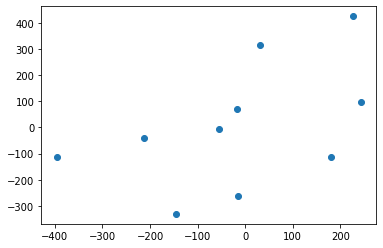

In [96]:
i = 50
Z_new = Z_state.reshape(Z.shape)
plt.scatter(Z_new[i, :, 0], -Z_new[i, :, 1])

(1000, 1, 20)


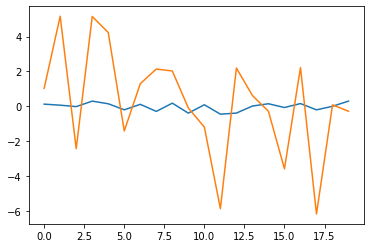

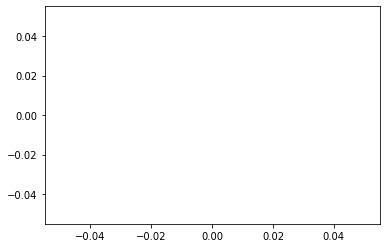

LinAlgError: SVD did not converge

In [74]:
np.random.seed(1)
N_sample = 1000
T, K_by_2, _ = Z_flat.shape
Z_state = np.zeros(Z_flat.shape)
V_state = np.zeros(Z_flat.shape)
c_state = np.zeros(Z_flat.shape)

################################################
#################### t = 0 #####################
################################################

# generate particles
v_sample = np.random.multivariate_normal(np.zeros(Z_flat[0, :, 0].shape), cov_v, N_sample)
v_sample = np.expand_dims(v_sample, axis=1)
# obtain the observed shape velocity from shape
v_observed = (np.eye(K_by_2) - Z_flat[0, :] @  Z_flat[0, :].T) @ Z_flat[0, :]
v_observed = np.expand_dims(v_observed, 0)
# use similarity score to estimate weight
weight = v_sample @ v_observed[0] / (np.linalg.norm(v_observed[0:1],axis=1,keepdims=True) * np.linalg.norm(v_sample, axis=2,keepdims=True))
# normalize weight to 1
# weight = np.exp(weight)
weight = weight / weight.sum()
# compute expected value of shape velocity
v_0 = (v_sample * weight).sum(axis=0)
# can do more iteration of sampling -> compute expected value if needed
# next_sample = np.random.choice(samples, weights) # this allows us to sample from a re-weighted distribution
# plt.plot(v_0[:, 0])
# plt.plot(v_observed[0, :, 0])
Z_state[0] = np.sqrt(1 - v_0 @ v_0.T) * Z_flat[0] + v_0.T
V_state[0] = v_0.T

# using observed value for Z, V and C
Z_state[0] = Z_flat[0]
# V_state[0] = (np.eye(K_by_2) - Z_state[0] @ Z_state[0].T) @ Z_flat[0]
T_z_im1 = (np.eye(K_by_2) - Z_state[0] @ Z_state[0].T) @ (np.eye(K_by_2) - np.ones((K_by_2, 1)) @ np.ones((1, K_by_2))/K_by_2)
U, _, _ = np.linalg.svd(T_z_im1)
c_state[0] = U @ Z_state[0]
################################################
#################### t = 1 #####################
################################################

v_sample = np.random.multivariate_normal((A @ V_state[0])[:, 0], cov_n, N_sample)
v_sample = np.expand_dims(v_sample, axis=1) # shape is (N_sample, 1, N x k)
# obtain the observed shape velocity from shape
v_observed = (np.eye(K_by_2) - Z_state[0, :] @  Z_state[0, :].T) @ Z_flat[1, :]
v_observed = np.expand_dims(v_observed, 0) # shape is (1, N x k ,1)
# use similarity score to estimate weight
weight = v_sample @ v_observed[0] / (np.linalg.norm(v_observed,axis=1,keepdims=True) * np.linalg.norm(v_sample, axis=2,keepdims=True))
# normalize weight to 1
# weight = np.exp(weight)
weight = weight / weight.sum() 
# compute expected value of shape velocity
v_0 = (v_sample * weight).sum(axis=0)
Z_state[1] = np.sqrt(max(0, 1 - v_0 @ v_0.T)) * Z_flat[0] + v_0.T
V_state[1] = v_0.T
T_z_im1 = (np.eye(K_by_2) - Z_state[0] @ Z_state[0].T) @ (np.eye(K_by_2) - np.ones((K_by_2, 1)) @ np.ones((1, K_by_2))/K_by_2)
U, _, _ = np.linalg.svd(T_z_im1)
c_state[1] = U @ Z_state[1]

################################################
#################### t >= 2 ####################
################################################

for i in range(2, T):
    T_z_im1 = (np.eye(K_by_2) - Z_state[i-1] @ Z_state[i-1].T) @ (np.eye(K_by_2) - np.ones((K_by_2, 1)) @ np.ones((1, K_by_2))/K_by_2)
    U_im1, _, _ = np.linalg.svd(T_z_im1)
    T_z_im2 = (np.eye(K_by_2) - Z_state[i-2] @ Z_state[i-2].T) @ (np.eye(K_by_2) - np.ones((K_by_2, 1)) @ np.ones((1, K_by_2))/K_by_2)
    U_im2, _, _ = np.linalg.svd(T_z_im2)
    A_c_t = U_im1.T @ A @ U_im2
    cov_c_t = U_im1.T @ cov_n @ U_im2
    c_sample = np.random.multivariate_normal((A_c_t @ c_state[i-1])[:, 0], cov_c_t, N_sample)
    c_sample = np.expand_dims(c_sample, axis=1)
    c_observed = U_im1.T @ Z_flat[i, :] 
    c_observed = np.expand_dims(c_observed, 0)
    # use similarity score to estimate weight
    weight = c_sample @ c_observed[0] / (np.linalg.norm(c_observed,axis=1,keepdims=True) * np.linalg.norm(c_sample, axis=2,keepdims=True))
    # normalize weight to 1
#     weight = np.exp(weight)
    weight = weight / weight.sum()
    c_t = (c_sample * weight).sum(axis=0)
    c_state[i] = c_t.T
    
    V_state[i] = U_im1 @ c_state[i]
    Z_state[i] = np.sqrt(1 - V_state[i].T @ V_state[i]) * Z_state[i-1] + V_state[i]
    
    plt.show()
    z_t_plot = Z_state[i].reshape(Z[0].shape)
    plt.scatter(z_t_plot[:, 0], -z_t_plot[:, 1])
    plt.show()
    
    


# 5. get rotation angle

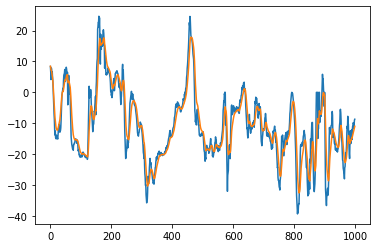

In [71]:
from scipy.spatial.transform import Rotation as Rot

min_cutoff = 0.03
beta = 0.0001
t_segment = [0, 1000]
r = R.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
out = r.as_euler('zyx', degrees=True)
dataSegment = data[t_segment[0]:t_segment[1]]
ref_frame = data[39]

dataSegment, rotations = rotateToNeutral(dataSegment[39], dataSegment, staticLandmarkIndices, True)
for i in range(0, len(rotations)):
    r = Rot.from_matrix(rotations[i])
    rotations[i] = r.as_euler('zyx', degrees=True)
rotations = np.array(rotations)
plt.plot(rotations[:,0])
rotations[:,0] = constrainedOneEuroFilter(rotations[:,0], t_segment, [39])
rotations[:,1] = constrainedOneEuroFilter(rotations[:,1], t_segment, [39])
rotations[:,2] = constrainedOneEuroFilter(rotations[:,2], t_segment, [39])
plt.plot(rotations[:,0])

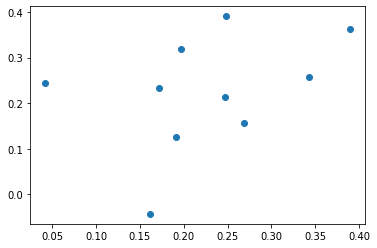

In [58]:
i = 2
Z_new = Z_state.reshape(Z.shape)
plt.scatter(Z_new[i, :, 0], -Z_new[i, :, 1])

In [72]:
outputToFile(rotation_output_path, np.array(rotations), fps, start, angle=True)

# 6. Particle filter implementation

In [12]:
import time


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def reweigh(samples, observation, cov, iteration=1):
   # samples should be of shape [N_sample, dims]
   # observation should be of shape [dims, ]
    samples = np.expand_dims(samples, axis=2)
    observation = np.expand_dims(np.expand_dims(observation, axis=0), axis=2)
#     weight = samples @ observation[0] / (np.linalg.norm(observation[0:1],axis=1,keepdims=True) * np.linalg.norm(samples, axis=2,keepdims=True))
#     weight = weight / weight.sum()
    inv_cov = np.diag(1.0/(cov.diagonal()))
    inv_cov = np.expand_dims(inv_cov, axis=0)
#     print(inv_cov.shape)
#     print((observation - samples).shape)
    
    prob = (observation - samples).transpose(0,2,1) @ inv_cov @ (observation - samples)
    prob = prob / prob.sum()
#     for i in range(0, iteration-1):
#         weight = weight * weight
#         weight = weight / weight.sum()
    v_0 = (samples * prob).sum(axis=0)
    return v_0.T 
def particle_filtering(Y, N_sample = 1000):
    # the input Y should data that has already been iteratively filtered for rotation, scale and translation
    # Y should be of shape [time_stamp, landmarkcount, 2]
    start_time = time.time()
    # center Y around mean
    original_mean = Y.mean(axis=1, keepdims=True) 
    Z = Y - original_mean
    # compute shape Z
    T, N, k = Z.shape
    Z_flat = Z.reshape(T, N*k, 1)
    Z_state = np.zeros(Z_flat.shape)
    Z_state[0] = Z_flat[0]

    print("--- %s seconds ---" % (time.time() - start_time))
    # find transition_covariance matrix
    delta_Z_transition = Z_flat[1:] - Z_flat[:-1]
    temp = delta_Z_transition  @ delta_Z_transition.transpose((0, 2, 1))
    cov_z_t = (temp.sum(axis=0))/(T-1)
    print("--- %s seconds ---" % (time.time() - start_time))
    delta_Z = Z_flat - moving_average(Z_flat, 10)
    temp = delta_Z  @ delta_Z.transpose((0, 2, 1))
    cov_z_n = (temp.sum(axis=0))/(T)
    print("--- %s seconds ---" % (time.time() - start_time))
    for i in range(1, T):
        prev_step = Z_state[i-1]
        next_step_sample = np.random.multivariate_normal((prev_step)[:, 0], cov_z_n, N_sample)
        Z_state[i] = reweigh(next_step_sample, Z_flat[i, :, 0], cov_z_n, 5).T
    return Z_state.reshape(T, N, k)

In [13]:
Y = data[t_segment[0]:t_segment[1]]
# compute shape Z
Y = iterativeNormalization(Y, Y[0], staticLandmarkIndices, staticLandmarkIndices)
Y_clean = particle_filtering(Y[:, keypointIndicies, 0:2])

--- 0.0 seconds ---
--- 0.026007413864135742 seconds ---
--- 8.764990329742432 seconds ---


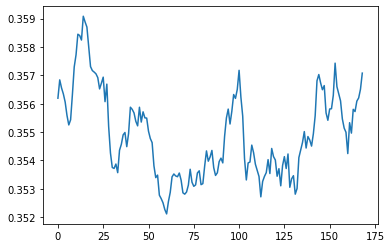

In [18]:
plt.plot(Y_clean.mean(axis=2).mean(axis=1))

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168


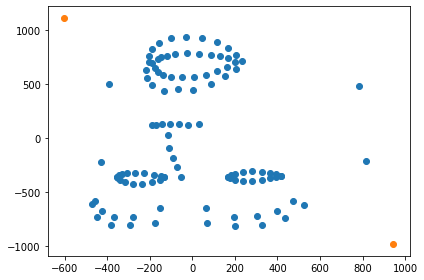

In [16]:
display_landmark(Y_clean, 30)

# 7. Optical flow assisted landmark stabilization

In [6]:
import cv2
from utils.canonical_face import ObjLoader

In [7]:
def lucas_kanade_method(video_path):
    # Read the video 
    cap = cv2.VideoCapture(video_path)

    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

    # Parameters for Lucas Kanade optical flow
    lk_params = dict(
        winSize=(9, 9),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    # Create random colors
    color = np.random.randint(0, 255, (100, 3))

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

In [22]:
 
# cv2.calcOpticalFlowPyrLK

lk_params = dict(
    winSize=(15, 15),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

cap = cv2.VideoCapture(videoPath)
t = 0
flow_data = []
video_shape = []
while cap.isOpened() and t < data.shape[0]:
    # obtain the image frame
    ret, frame_t1 = cap.read()
    if frame_t1 is None:
        break
    # obtain the landmark frame:
    lm_t1 = data[max(0, t-1), keypointIndicies].astype(np.float32)
    
    # un-normalize the position by multiplying by the frame size
    lm_t1[:, 0] = lm_t1[:, 0] * frame_t1.shape[1]
    lm_t1[:, 1] = lm_t1[:, 1] * frame_t1.shape[0]
    ##### calculate optical flow #####
    # convert to gray scale
    frame_t1_gray = cv2.cvtColor(frame_t1, cv2.COLOR_BGR2GRAY)
    lm_t1 = np.expand_dims(lm_t1, axis=1)[:, :, 0:2]
    if t == 0:
        video_shape = frame_t1_gray.shape
        frame_t0_gray = frame_t1_gray.copy()
        
        lm_t1 = data[0, keypointIndicies].astype(np.float32)
        # un-normalize the position by multiplying by the frame size
        lm_t1[:, 0] = lm_t1[:, 0] * frame_t1.shape[1]
        lm_t1[:, 1] = lm_t1[:, 1] * frame_t1.shape[0]
        ##### calculate optical flow #####
        # convert to gray scale
        frame_t1_gray = cv2.cvtColor(frame_t1, cv2.COLOR_BGR2GRAY)
        lm_t1 = np.expand_dims(lm_t1, axis=1)[:, :, 0:2]
        p_t0 = lm_t1
        
        flow_data.append(p_t0[:, 0, :])
        t = t+1
        continue
    p_t1, st, err = cv2.calcOpticalFlowPyrLK(
        frame_t0_gray, frame_t1_gray, p_t0, None, **lk_params
    )
    # Select good points
    good_new = p_t1[st == 1]
    good_old = p_t0[st == 1]
    flow_data.append(np.where(st==1, p_t1[:, 0, :], p_t0[:, 0, :]))
    # display both, not important
#     display_frame = np.zeros(frame_t1.shape)
#     display_frame[:, :, 0] = frame_t1[:, :, 2]
#     display_frame[:, :, 1] = frame_t1[:, :, 1]
#     display_frame[:, :, 2] = frame_t1[:, :, 0]
#     display_frame = display_frame/255.0
#     plt.imshow(display_frame)
#     plt.scatter(lm_t1[:, 0, 0], lm_t1[:, 0, 1], s=5)
#     plt.scatter(good_new[:, 0], good_new[:, 1], s=5)
#     plt.show()
    #     cv2.imwrite("frame%d.jpg" % count, frame)
    t = t + 1
    frame_t0_gray = frame_t1_gray.copy()
    p_t0 = lm_t1
cap.release()
# re-scale the optical flow data     
flow_data = np.array(flow_data)
flow_data[:, :, 0] = flow_data[:, :, 0] / video_shape[1]
flow_data[:, :, 1] = flow_data[:, :, 1] / video_shape[0] 
flow_data_3d = data[:, keypointIndicies].copy()
flow_data_3d[:, :, 0:2] = flow_data

## quadratic_solver

In [23]:
alpha = 1/2.2
beta = 0.2/2.2
gamma = 2/2.2
lm_data_3d = data[:, keypointIndicies]
flow_data_3d = flow_data_3d

In [24]:
from qpsolvers import solve_qp
# normalize to canonical direction
face = ObjLoader("./data/canonical_face_model.obj")
lm_data_to_canonical = iterativeNormalization(data, face.vertices, staticLandmarkIndices, staticLandmarkIndices)[:, keypointIndicies]
flow_data_3d_to_canonical = iterativeNormalization(flow_data_3d, face.vertices[keypointIndicies], np.arange(0, len(staticLandmarkIndices)), np.arange(0, len(staticLandmarkIndices)))

lm_data_to_canonical = rotateToNeutral(face.vertices, data, staticLandmarkIndices)[:, keypointIndicies]
# flow_data_3d_to_canonical = rotateToNeutral(face.vertices[keypointIndicies], flow_data_3d, np.arange(0, len(staticLandmarkIndices)))

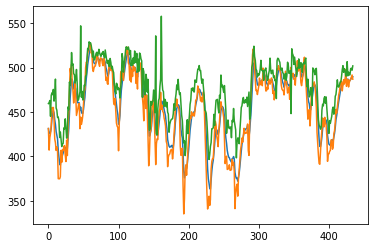

In [28]:
N_landmakrs, N_dims = lm_data_to_canonical[0].shape
qp_sols = [lm_data_to_canonical[0].reshape(N_landmakrs*N_dims)]
for i in range(1, lm_data_to_canonical.shape[0]):
    L_lm_t = lm_data_to_canonical[i].reshape(N_landmakrs*N_dims)
    L_fl_t = flow_data_3d_to_canonical[i].reshape(N_landmakrs*N_dims)
    L_lm_prev = qp_sols[-1]
    P = (alpha + beta + gamma) * np.eye(N_landmakrs*N_dims)
    q = -2*(alpha * L_lm_t + beta * L_fl_t + gamma * L_lm_prev)    
    L = solve_qp(P, q, initvals=L_lm_t)/2
    qp_sols.append(L)
L_stabilized = np.array(qp_sols)
L_stabilized = L_stabilized.reshape((L_stabilized.shape[0], N_landmakrs, N_dims))
plt.plot(L_stabilized.sum(axis=2).sum(axis=1))
plt.plot(lm_data_to_canonical.sum(axis=2).sum(axis=1))
plt.plot(flow_data_3d_to_canonical.sum(axis=2).sum(axis=1))

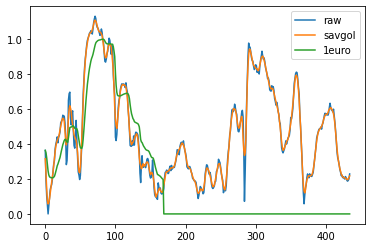

In [29]:
Brow_on_stable_face = list(range(len(maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]), 
                                len(maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
                    +maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"])))


keypointIndicies = (maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
                    +maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]
                    +maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]
                    +maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"])


leftBrowDistanceFromNeutral = np.square(L_stabilized[:,Brow_on_stable_face,1:2]-L_stabilized[4:5,Brow_on_stable_face,1:2])[:,:,0:2].mean(axis=2)
leftBrowDistanceFromNeutral = np.sqrt(leftBrowDistanceFromNeutral.mean(axis=1))
smoothed_signal = signal.savgol_filter(leftBrowDistanceFromNeutral, min(5, np.floor(leftBrowDistanceFromNeutral.shape[0]/2)*2-1), 1)
plt.plot(leftBrowDistanceFromNeutral[:], label="raw")
plt.plot(smoothed_signal, label="savgol")
t = np.arange(0, dataSegment.shape[0])
x_hat = np.zeros_like(leftBrowDistanceFromNeutral)
x_hat[0] = leftBrowDistanceFromNeutral[0]
one_euro_filter = OneEuroFilter(t[0], leftBrowDistanceFromNeutral[0],min_cutoff=min_cutoff,beta=beta)
for i in range(1, len(t)):
    x_hat[i] = one_euro_filter(t[i], leftBrowDistanceFromNeutral[i])
plt.plot(x_hat, label="1euro")
plt.legend()
# outputToFile(outputPath, x_hat, fps, 0)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


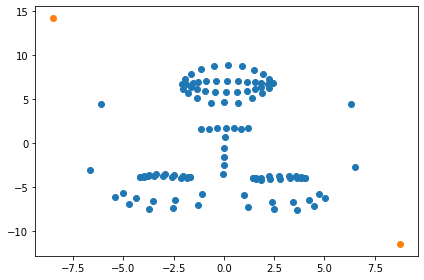

In [27]:
L_stabilized[:, :, 1] = -L_stabilized[:, :, 1]
display_landmark(L_stabilized, 30)

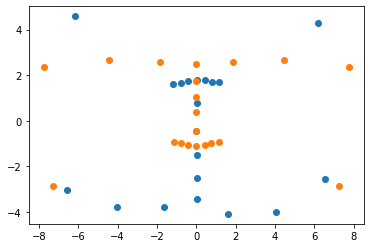

In [89]:
i = -1
plt.scatter(flow_data_3d_to_canonical[i, np.arange(0, len(staticLandmarkIndices)), 0], -flow_data_3d_to_canonical[i, np.arange(0, len(staticLandmarkIndices)), 1])
plt.scatter(face.vertices[staticLandmarkIndices][:,0], face.vertices[staticLandmarkIndices][:,1])